# Important Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image, ImageFilter
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing import image
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import time
from tensorflow.keras.applications import VGG16

# Data Preprocessing

In [2]:
# Define constants
image_size = (224, 224)

train_dir = '/kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images'
batch_size = 64

In [3]:
# Function to load data
def load_data(data_dir):
    """Load images and labels from the directory."""
    images = []
    labels = []
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            main_label = label.split("___")[0]  # Extract main label
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):
                    try:
                        img = Image.open(img_path).convert('RGB')
                        img = img.resize(image_size)
                        img_array = np.array(img)
                        images.append(img_array)
                        labels.append(main_label)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
    return np.array(images), np.array(labels)

In [4]:
# Load data
train_images, train_labels = load_data(train_dir)
#val_images, val_labels = load_data(val_dir)

# Normalize images to [0, 1]
train_images = train_images / 255.0
#val_images = val_images / 255.0

In [5]:
# Split training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

In [6]:
# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

In [7]:
# Compute class weights for imbalanced data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_encoded),
    y=train_labels_encoded
)
class_weights = dict(enumerate(class_weights))

# One-hot encode labels
num_classes = len(label_encoder.classes_)
train_labels_one_hot = to_categorical(train_labels_encoded, num_classes=num_classes)
val_labels_one_hot = to_categorical(val_labels_encoded, num_classes=num_classes)

In [8]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()

In [9]:
# Data generators
train_generator = train_datagen.flow(
    train_images, train_labels_one_hot, batch_size=batch_size
)
validation_generator = val_datagen.flow(
    val_images, val_labels_one_hot, batch_size=batch_size
)

# Debug information
print(f"Training set: {len(train_images)} samples")
print(f"Validation set: {len(val_images)} samples")
print(f"Number of classes: {num_classes}")
print(f"Class weights: {class_weights}")

Training set: 1056 samples
Validation set: 264 samples
Number of classes: 9
Class weights: {0: 0.9386666666666666, 1: 1.8333333333333333, 2: 1.002849002849003, 3: 0.8691358024691358, 4: 1.7777777777777777, 5: 1.8333333333333333, 6: 1.1733333333333333, 7: 1.9234972677595628, 8: 0.36213991769547327}


In [10]:
# Save validation dataset images (optional)
def save_validation_images(images, labels, save_to_dir):
    os.makedirs(save_to_dir, exist_ok=True)
    for idx, (image, label) in enumerate(zip(images, labels)):
        label_dir = os.path.join(save_to_dir, str(label))
        os.makedirs(label_dir, exist_ok=True)
        img = Image.fromarray((image * 255).astype(np.uint8))
        img_path = os.path.join(label_dir, f'{label}_{idx}.jpeg')
        img.save(img_path)

save_validation_images(val_images, val_labels_encoded, '/kaggle/working/validation_dataset')

# Debug directory structure
def debug_directory_structure(data_dir):
    for dirname, _, filenames in os.walk(data_dir):
        print(f"Directory: {dirname}, Files: {len(filenames)}")

debug_directory_structure('/kaggle/working/validation_dataset')

Directory: /kaggle/working/validation_dataset, Files: 0
Directory: /kaggle/working/validation_dataset/5, Files: 16
Directory: /kaggle/working/validation_dataset/6, Files: 20
Directory: /kaggle/working/validation_dataset/0, Files: 35
Directory: /kaggle/working/validation_dataset/1, Files: 16
Directory: /kaggle/working/validation_dataset/4, Files: 14
Directory: /kaggle/working/validation_dataset/8, Files: 76
Directory: /kaggle/working/validation_dataset/7, Files: 19
Directory: /kaggle/working/validation_dataset/3, Files: 25
Directory: /kaggle/working/validation_dataset/2, Files: 43


# Data Visualization

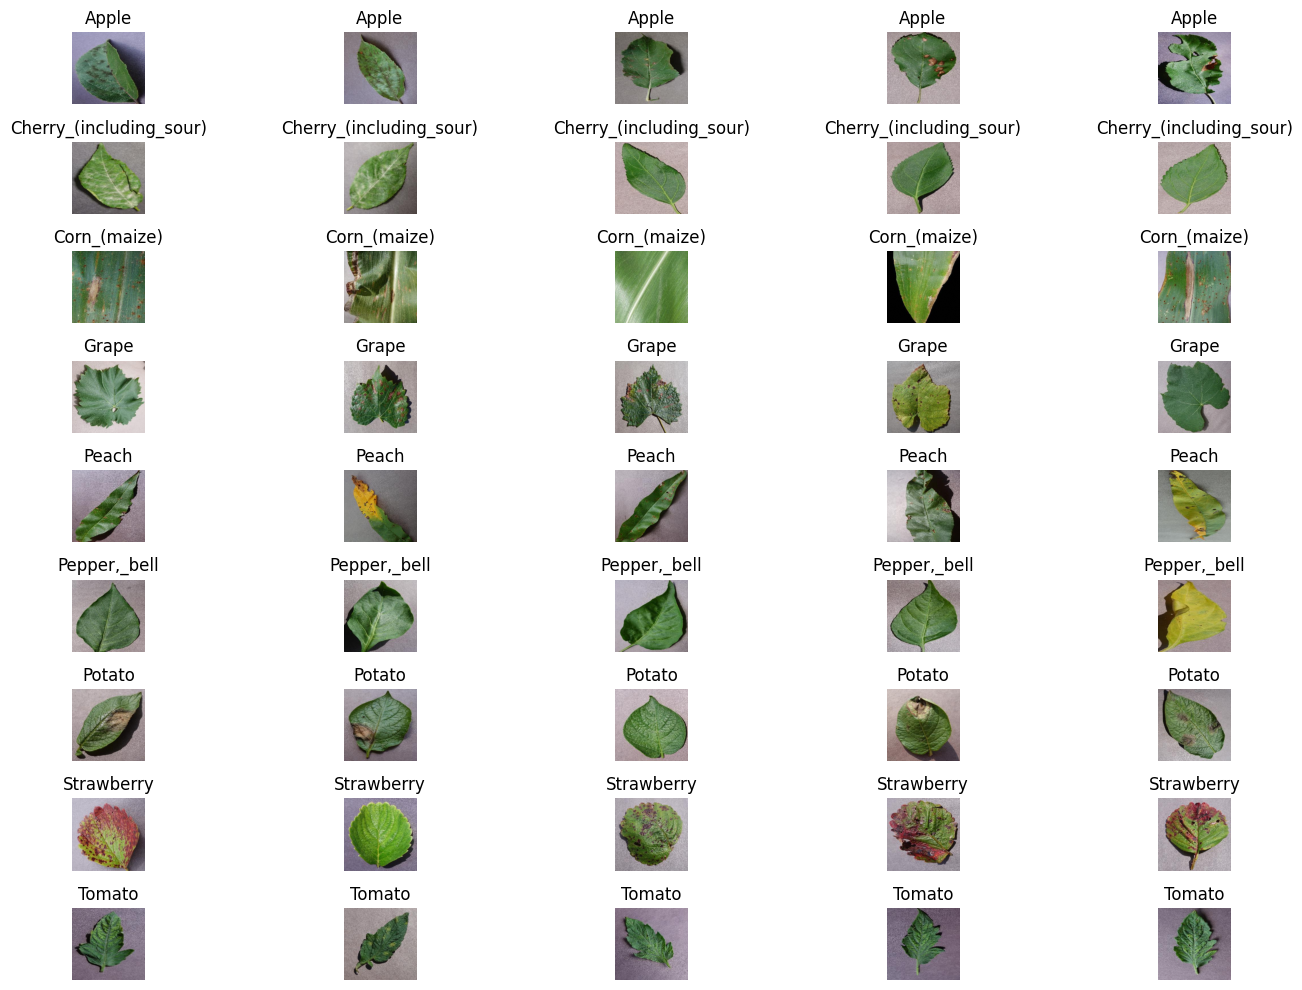

In [11]:
import matplotlib.pyplot as plt
import random

def visualize_samples(images, labels, label_encoder, num_samples=5):
    """Visualize a few sample images from each class."""
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15, 10))
    for i, label in enumerate(unique_labels):
        label_indices = np.where(labels == label)[0]
        selected_indices = random.sample(list(label_indices), min(num_samples, len(label_indices)))
        for j, idx in enumerate(selected_indices):
            plt.subplot(len(unique_labels), num_samples, i * num_samples + j + 1)
            plt.imshow(images[idx])
            plt.title(label_encoder.inverse_transform([label])[0])
            plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(train_images, train_labels_encoded, label_encoder)


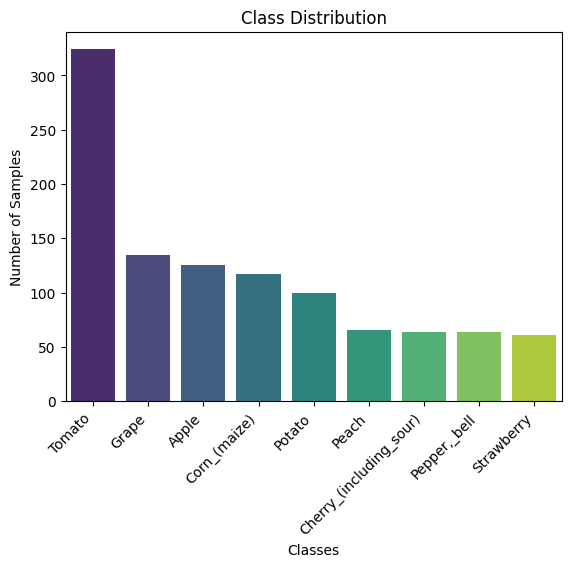

In [12]:
import seaborn as sns
import pandas as pd

def plot_class_distribution(labels, label_encoder):
    """Plot the distribution of classes."""
    label_counts = pd.Series(labels).value_counts()
    label_names = label_encoder.inverse_transform(label_counts.index)
    sns.barplot(x=label_names, y=label_counts.values, palette="viridis")
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    plt.xticks(rotation=45, ha='right')
    plt.show()

plot_class_distribution(train_labels_encoded, label_encoder)


In [13]:
# Define test directory (update path as needed)
test_dir = '/kaggle/input/cv25-project-dataset/Project Data/Project Data/Val/images'

In [14]:
# Function to load test data
def load_test_data(data_dir):
    images = []
    labels = []
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            main_label = label.split("___")[0]  # Extract main label
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):
                    try:
                        img = Image.open(img_path).convert('RGB')
                        img = img.resize(image_size)
                        img_array = np.array(img)
                        images.append(img_array)
                        labels.append(main_label)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
    return np.array(images), np.array(labels)

In [15]:
# Load test data
test_images, test_labels = load_test_data(test_dir)

# Normalize test images to [0, 1]
test_images = test_images / 255.0

# Encode test labels
test_labels_encoded = label_encoder.transform(test_labels)

# One-hot encode test labels
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes=num_classes)


In [16]:
# Create test generator
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(
    test_images, test_labels_one_hot, batch_size=batch_size, shuffle=False
)

# MobileNet

In [17]:
# Load MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(*image_size, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# Start tracking training time
start_training_time = time.time()

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Adjust epochs as needed
    class_weight=class_weights
)

# End tracking training time
end_training_time = time.time()

# Calculate training time
training_time = end_training_time - start_training_time
print(f"Training Time: {training_time:.2f} seconds")
# Get final training accuracy
# Calculate average training accuracy
average_training_accuracy = sum(history.history['accuracy']) / len(history.history['accuracy'])
print(f"Training Accuracy: {average_training_accuracy:.2f}")

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734538680.400208      91 service.cc:145] XLA service 0x7f60c000c150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734538680.400272      91 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3:27 13s/step - accuracy: 0.0469 - loss: 2.8073

I0000 00:00:1734538685.973019      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 663ms/step - accuracy: 0.3641 - loss: 2.2047 - val_accuracy: 0.8826 - val_loss: 0.3543
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 366ms/step - accuracy: 0.8486 - loss: 0.4785 - val_accuracy: 0.9394 - val_loss: 0.2005
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.9137 - loss: 0.2727 - val_accuracy: 0.9280 - val_loss: 0.2055
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step - accuracy: 0.9209 - loss: 0.1726 - val_accuracy: 0.9621 - val_loss: 0.1049
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 371ms/step - accuracy: 0.9543 - loss: 0.1235 - val_accuracy: 0.9697 - val_loss: 0.0959
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.9604 - loss: 0.1105 - val_accuracy: 0.9735 - val_loss: 0.0845
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 372ms/step - accuracy: 0.9613 - loss: 0.0992 - val_accuracy: 0.9470 - val_loss: 0.1212
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 370ms/step - accuracy: 0.9542 - loss: 0.1082 - val_accuracy: 0.962

In [19]:
# Start tracking testing time
start_testing_time = time.time()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)

# End tracking testing time
end_testing_time = time.time()

# Calculate testing time
testing_time = end_testing_time - start_testing_time
print(f"Testing Time: {testing_time:.2f} seconds")
# Print test results
print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - accuracy: 0.9746 - loss: 0.0800
Testing Time: 1.93 seconds
Test Accuracy: 0.97, Test Loss: 0.08


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step
Classification Report of MobileNET:
                         precision    recall  f1-score   support

                  Apple       0.97      0.97      0.97        40
Cherry_(including_sour)       0.90      0.95      0.93        20
           Corn_(maize)       1.00      1.00      1.00        40
                  Grape       1.00      0.95      0.97        40
                  Peach       1.00      0.95      0.97        20
           Pepper,_bell       0.87      1.00      0.93        20
                 Potato       1.00      0.97      0.98        30
             Strawberry       0.95      1.00      0.98        20
                 Tomato       0.98      0.97      0.97       100

               accuracy                           0.97       330
              macro avg       0.96      0.97      0.97       330
           weighted avg       0.97      0.97      0.97       330



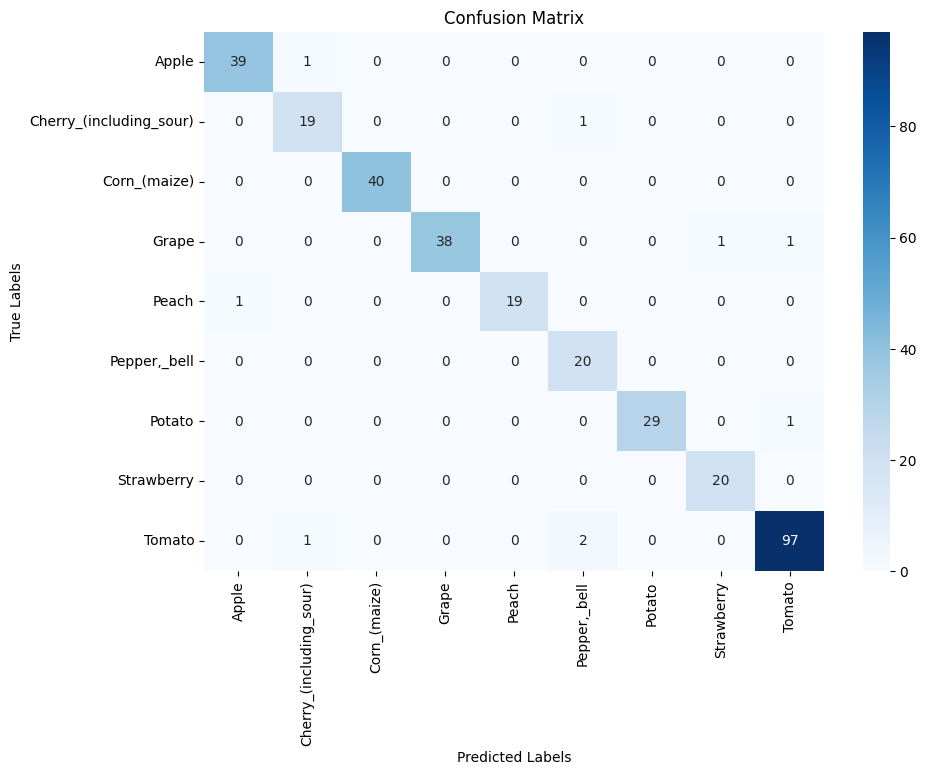

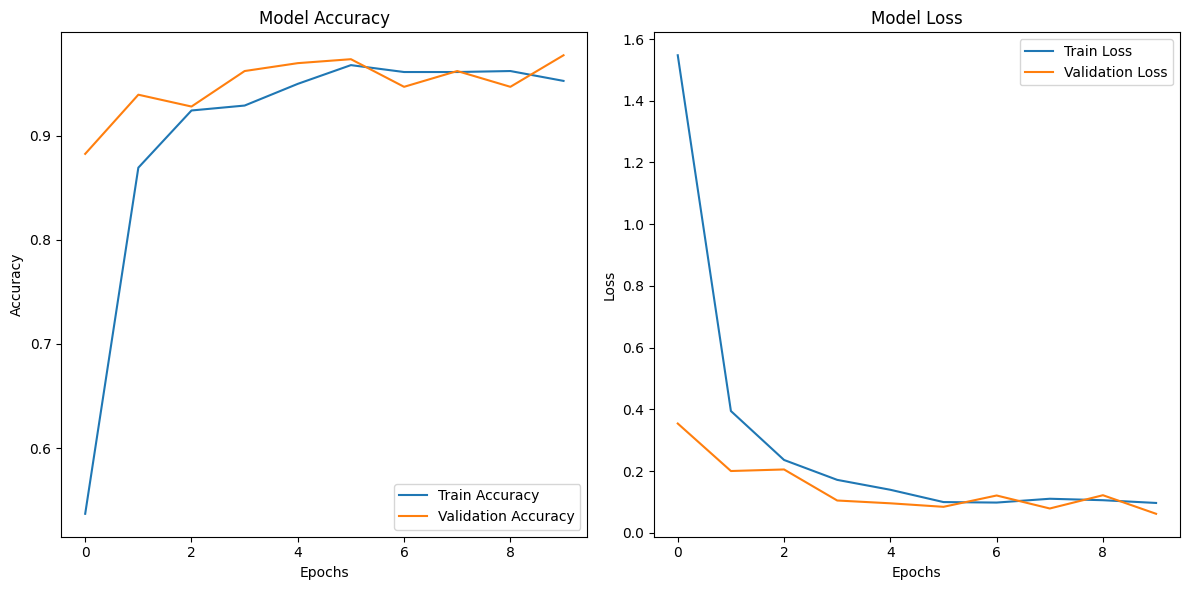

In [20]:
# Predict on the test data
predictions = model.predict(test_generator)

# Get the predicted labels (using argmax for classification)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels (from the test generator)
true_labels = test_labels_encoded

# Classification Report with Plant Names
print("Classification Report of MobileNET:")
print(classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix with plant names as labels
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Accuracy and Loss Visualization (if you saved the history of training)
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# AlexNet

In [37]:
# Define AlexNet model
model = Sequential()

# Convolutional layers and max pooling layers (AlexNet architecture)
model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Output layer

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

start_training_time = time.time()

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Adjust epochs as needed
    class_weight=class_weights
)

# End tracking training time
end_training_time = time.time()

# Calculate training time
training_time = end_training_time - start_training_time
print(f"Training Time: {training_time:.2f} seconds")


# Calculate average training accuracy
average_training_accuracy = sum(history.history['accuracy']) / len(history.history['accuracy'])
print(f"Training Accuracy: {average_training_accuracy:.2f}")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 540ms/step - accuracy: 0.0878 - loss: 5.5885 - val_accuracy: 0.0606 - val_loss: 2.1996
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 378ms/step - accuracy: 0.0856 - loss: 2.1764 - val_accuracy: 0.0720 - val_loss: 2.1992
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.0705 - loss: 2.2177 - val_accuracy: 0.0720 - val_loss: 2.1976
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 391ms/step - accuracy: 0.0941 - loss: 2.2217 - val_accuracy: 0.0530 - val_loss: 2.1919
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 385ms/step - accuracy: 0.0855 - loss: 2.2238 - val_accuracy: 0.0530 - val_loss: 2.1945
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 392ms/step - accuracy: 0.0916 - loss: 2.2143 - val_accuracy: 0.2879 - val_loss: 2.1874
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 371ms/step - accuracy: 0.1250 - loss: 2.2023 - val_accuracy: 0.1629 - val_loss: 2.1864
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 375ms/step - accuracy: 0.0750 - loss: 2.1990 - val_accu

In [35]:
# Start tracking testing time
start_testing_time = time.time()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)

# End tracking testing time
end_testing_time = time.time()

# Calculate testing time
testing_time = end_testing_time - start_testing_time
print(f"Testing Time: {testing_time:.2f} seconds")

# Print test results
print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.3686 - loss: 2.1948
Testing Time: 0.75 seconds
Test Accuracy: 0.30, Test Loss: 2.20


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Classification Report of AlexNet:
                         precision    recall  f1-score   support

                  Apple       0.00      0.00      0.00        40
Cherry_(including_sour)       0.00      0.00      0.00        20
           Corn_(maize)       0.00      0.00      0.00        40
                  Grape       0.00      0.00      0.00        40
                  Peach       0.00      0.00      0.00        20
           Pepper,_bell       0.00      0.00      0.00        20
                 Potato       0.00      0.00      0.00        30
             Strawberry       0.00      0.00      0.00        20
                 Tomato       0.30      1.00      0.47       100

               accuracy                           0.30       330
              macro avg       0.03      0.11      0.05       330
           weighted avg       0.09      0.30      0.14       330



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


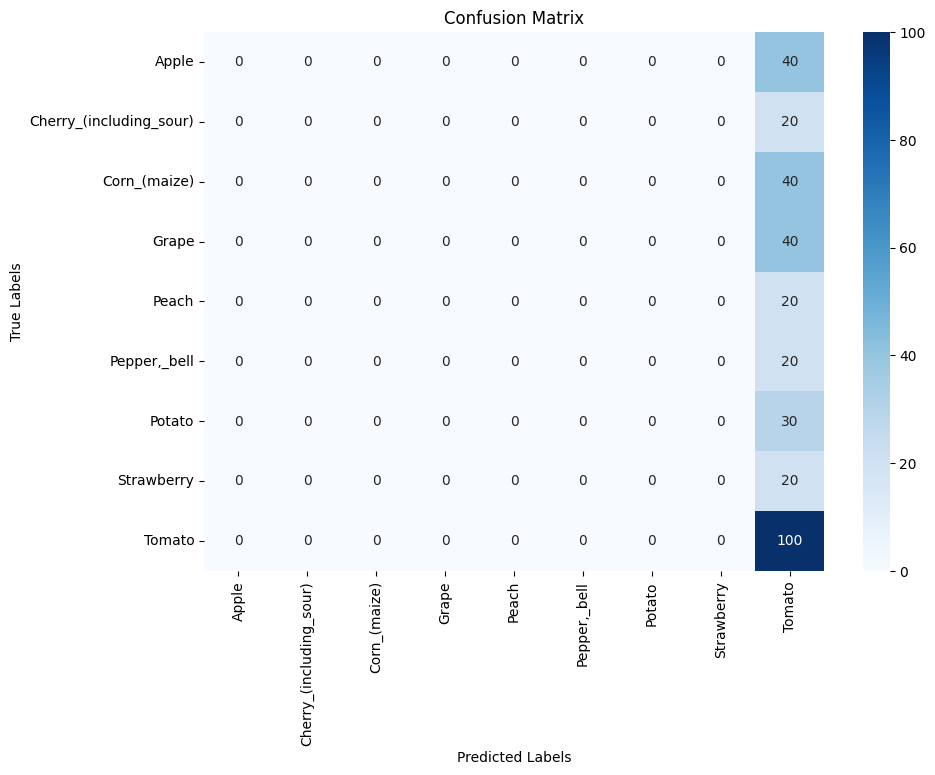

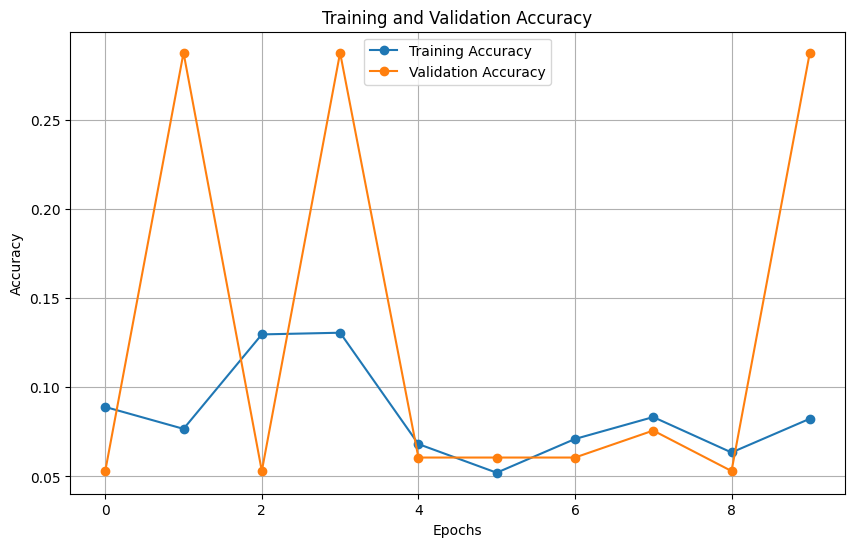

In [36]:
# Predict on the test data
predictions = model.predict(test_generator)

# Get the predicted labels (using argmax for classification)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels (from the test generator)
true_labels = test_labels_encoded

# Classification Report with Plant Names
print("Classification Report of AlexNet:")
print(classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix with plant names as labels
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# VGG

In [38]:
# Define VGG16 model with pre-trained weights (without top classification layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Build the new model with custom layers on top of VGG16
model = Sequential()
model.add(base_model)  # Add the VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dense(4096, activation='relu'))  # Fully connected layer
model.add(Dropout(0.5))  # Dropout to reduce overfitting
model.add(Dense(4096, activation='relu'))  # Another fully connected layer
model.add(Dropout(0.5))  # Dropout to reduce overfitting
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

start_training_time = time.time()
# Train model (Note: You need to define 'train_generator' and 'validation_generator' for training)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Adjust epochs as needed
    class_weight=class_weights
)

# End tracking training time
end_training_time = time.time()

# Calculate training time
training_time = end_training_time - start_training_time
print(f"Training Time: {training_time:.2f} seconds")

# Calculate average training accuracy
average_training_accuracy = sum(history.history['accuracy']) / len(history.history['accuracy'])
print(f"Training Accuracy: {average_training_accuracy:.2f}")

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 545ms/step - accuracy: 0.1533 - loss: 19.3983 - val_accuracy: 0.2576 - val_loss: 1.9804
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 420ms/step - accuracy: 0.2863 - loss: 1.9541 - val_accuracy: 0.5682 - val_loss: 1.1340
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 427ms/step - accuracy: 0.5178 - loss: 1.2809 - val_accuracy: 0.7803 - val_loss: 0.7127
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 448ms/step - accuracy: 0.6076 - loss: 1.0726 - val_accuracy: 0.7614 - val_loss: 0.6343
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 421ms/step - accuracy: 0.6469 - loss: 0.9360 - val_accuracy: 0.7348 - val_loss: 0.6309
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 423ms/step - accuracy: 0.6846 - loss: 0.9048 - val_accuracy: 0.8598 - val_loss: 0.4267
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 425ms/step - accuracy: 0.7067 - loss: 0.7273 - val_accuracy: 0.8523 - val_loss: 0.4017
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 421ms/step - accuracy: 0.7123 - loss: 0.7875 - val_acc

In [31]:
# Start tracking testing time
start_testing_time = time.time()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)

# End tracking testing time
end_testing_time = time.time()

# Calculate testing time
testing_time = end_testing_time - start_testing_time
print(f"Testing Time: {testing_time:.2f} seconds")

# Print test results
print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.8813 - loss: 0.3536
Testing Time: 1.10 seconds
Test Accuracy: 0.88, Test Loss: 0.35


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
Classification Report of VGG:
                         precision    recall  f1-score   support

                  Apple       1.00      0.45      0.62        40
Cherry_(including_sour)       0.50      1.00      0.67        20
           Corn_(maize)       1.00      0.97      0.99        40
                  Grape       0.93      0.97      0.95        40
                  Peach       0.73      0.95      0.83        20
           Pepper,_bell       1.00      0.95      0.97        20
                 Potato       0.96      0.80      0.87        30
             Strawberry       0.82      0.90      0.86        20
                 Tomato       0.95      0.94      0.94       100

               accuracy                           0.88       330
              macro avg       0.88      0.88      0.86       330
           weighted avg       0.91      0.88      0.88       330



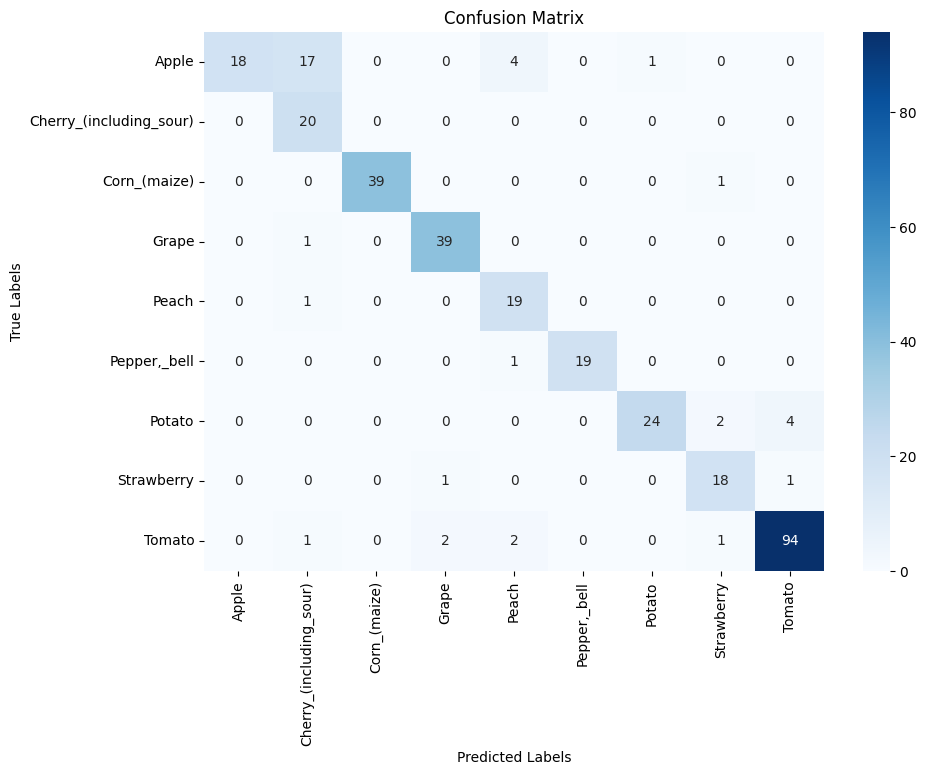

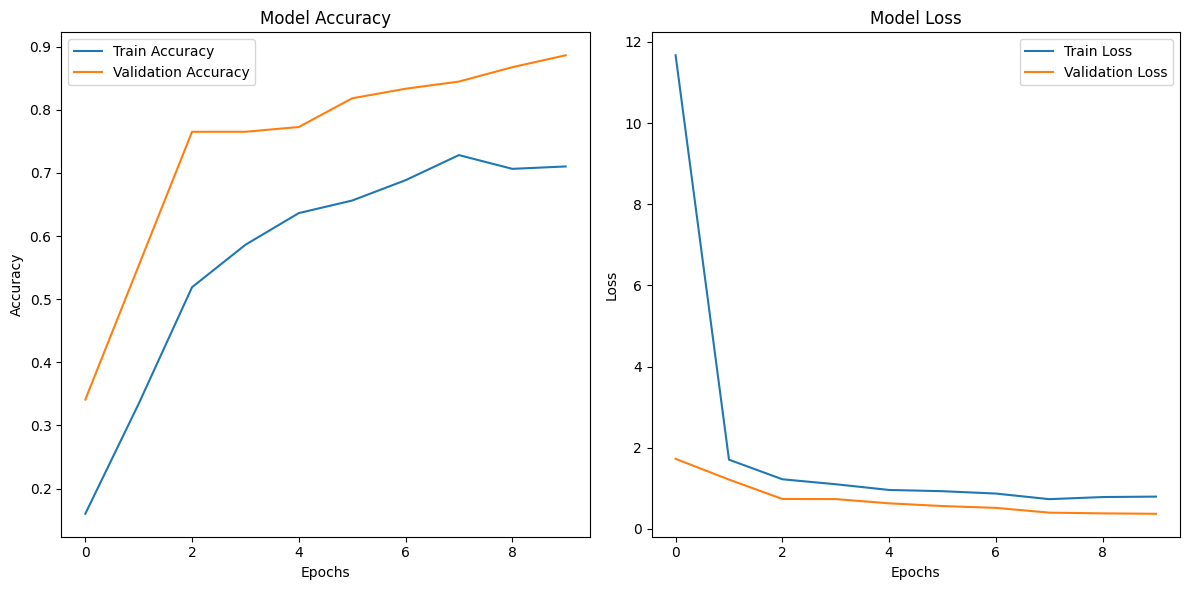

In [32]:
# Predict on the test data
predictions = model.predict(test_generator)

# Get the predicted labels (using argmax for classification)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels (from the test generator)
true_labels = test_labels_encoded

# Classification Report with Plant Names
print("Classification Report of VGG:")
print(classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix with plant names as labels
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Accuracy and Loss Visualization (if you saved the history of training)
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()